# Applying classic CNN models: NN vs LeNet vs AlexNet

In this practice you will apply different Neural Networks models to solve a set of problems:
1. First, we start with lego bricks and try to classify them with using basic models
2. Next, we will apply same models for FashionMNIST dataset, it contains 60K samples of 10 classes
3. Then we will use higher-dimension pictures and will see whether thee techniques still works



## Part I: Lego bricks

As for beginning, lets follow the already known example - Lego bricks, brought by Linux Academy (its not exist anymore though :( ). And compare their model to some classic models that you will build: LeNet & AlexNet.


### Task 1.1 - Neural Network (MLP)

**Task: Use Lego bricks dataset and model to classify samples**


Original Notebook: [https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb](https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb)

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [9]:
# Open the files:
train_fh = open('data/lego-train.pickle', 'rb')
test_fh = open('data/lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 


In [5]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

train_data = train_data.transform_first(transformer)
test_data = test_data.transform_first(transformer)

AttributeError: 'list' object has no attribute 'transform_first'

Original shape is  (48, 48, 1)


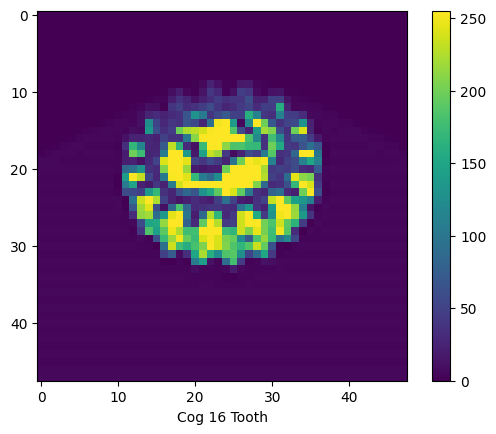

In [8]:
train_image_no = 64

images_data, label_data = train_data[train_image_no]
print('Original shape is ', images_data.shape)
plt.figure()
plt.imshow(images_data.reshape((48,48)))
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [21]:
# Define a neural network as per the original lab
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(1.0)

def build_NN():
    net = nn.Sequential(
        nn.Flatten(),#матрицу вытягивает в вкетор
        nn.Linear(128),#128 нейронов
        nn.Sigmoid(),
        nn.Linear(64),
        nn.Sigmoid(),
        nn.Linear(10),
        nn.Sigmoid(),
        nn.Softmax()#необязат, делает так чтоб все нейроны в сумме давали 1
    )
    
    net.apply(init_weights())#инициализация весов
    
    return net

In [20]:
from tqdm import tqdm
# lets use some fancy visualization of progress - https://github.com/tqdm/tqdm

In [23]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_data, device, num_epochs):

    # reinitialize network and start from scratch
    # trainer = gluon.Trainer(
    #     params=net.collect_params(),
    #     optimizer='sgd', optimizer_params={'learning_rate': 0.05},
    # )
    optimizer = optim.SGD(net.parameters(), lr=0.051, momentum=0.9)

    # metric = mx.metric.Accuracy()
    # loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
    loss_function = nn.CrossEntropyLoss()#функция потерь
    
    history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:#неважно , рисует прогрес бар

        for epoch in range(num_epochs):#кол-во эпох-сколько раз модель просмотрела датасет
            running_loss = 0.0
            for batch_num, (inputs, labels) in enumerate(train_data):
                # Possibly copy inputs and labels to the GPU
                inputs = torch.from_numpy(inputs).to(device)
                labels = torch.tensor(labels).to(device)
                
                optimizer.zero_grad()

                # Forward pass
                # with autograd.record():
                #     outputs = net(inputs)
                #     loss = loss_function(outputs, labels)
                
                outputs = net(inputs)#даем-входные зн-ия-картинки
                loss = loss_function(outputs, labels)#сравниваем резуль-ат с истинными зн-иями

                # Backpropagation
                # loss.backward()
                # metric.update(labels, outputs)
                
                loss.backward()#считаем обратное распр-ие ошибки, т.е. снижаем loss. Тут подстраиваются коэф-иенты

                # Update
                # trainer.step(batch_size = inputs.shape[0])
                optimizer.step()

                # Print progress
                running_loss += loss.item()
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %f" % (epoch, batch_num, running_loss))
                pbar.update()

            # Print the evaluation metric and reset it for the next epoch
            # name, acc = metric.get()
            # history.insert(epoch,acc)
            # metric.reset()

        pbar.close()

    return history


In [23]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')#в рамках каждой эпохе строим динамику по accuracy
    plt.xlabel('Epoch')

In [28]:
# prepare training
batch_size = 32 #здесь запускаем обучение
epochs = 100
#Learning rate - отвечает за шаг изменения коэффициентов
train_loader = mx.gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [24]:
net = build_NN()

TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'

In [25]:
print(net)

NameError: name 'net' is not defined

In [22]:
hist = train(net, train_loader, ctx, epochs)

Epoch: 99, Batch: 14, Loss: 0.002637: 100%|██████████| 1500/1500 [00:09<00:00, 157.59it/s]


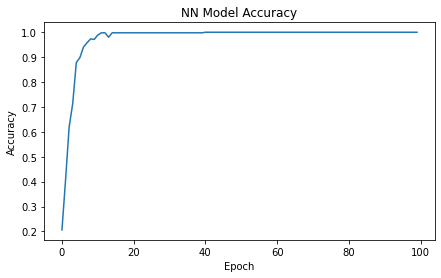

In [24]:
print_history(hist, "NN Model Accuracy")

### Task 1.2 - CNNs (LeNet + AlexNet)

Task: build classic CNN models (LeNet & AlexNet) and apply them for classification

LeNet is a classic neural network, that we can use to validate CNN approach on top of same Lego bricks dataset.
Compare and discuss what are the differences of LeNet & AlexNet architectures.

<br/>
<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1920px-Comparison_image_neural_networks.svg.png" width="800"/>
</div>

In [101]:
def build_lenet():
    net = nn.HybridSequential(prefix='LeNet_')
    with net.name_scope():
        net.add(
            nn.Conv2D(kernel_size=5, channels=6, padding=(2,2), activation="sigmoid"),
            nn.AvgPool2D(pool_size=(2,2), stride=(2,2)),
            nn.Conv2D(kernel_size=5, channels=16),#разбивает ядро размером 5 на 16 каналов и третий пар-етр нужен тоже 5
            nn.Activation("sigmoid"),
            nn.AvgPool2D(pool_size=(2,2), stride=(2,2)),
            nn.Flatten(),
            nn.Dense(120, activation='sigmoid'),
            nn.Dense(84, activation='sigmoid'),
            nn.Dense(10, activation=None)
        )

    return net

In [102]:
lenet = build_lenet()

In [103]:
print(lenet)

HybridSequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
  (1): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  (2): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (3): Activation(relu)
  (4): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  (5): Flatten
  (6): Dense(None -> 120, Activation(relu))
  (7): Dense(None -> 84, Activation(relu))
  (8): Dense(None -> 10, linear)
)


In [89]:
hist_lenet = train(lenet, train_loader, ctx, epochs)

Epoch: 99, Batch: 14, Loss: 2.235476: 100%|██████████| 1500/1500 [00:48<00:00, 31.20it/s]


In [104]:
hist_lenet2 = train(lenet, train_loader, ctx, 100)

Epoch: 99, Batch: 14, Loss: 0.000048: 100%|██████████| 1500/1500 [00:50<00:00, 29.81it/s]


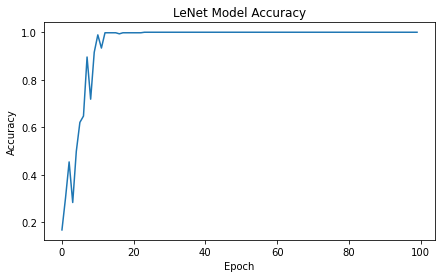

In [105]:
print_history(hist_lenet2, "LeNet Model Accuracy")

### Task 1.3 - Evaluate results

Task: Compare NN with given architectures. Discuss, why results are different

In [33]:
def evaluate_acc(net, test_loader):
    metric = mx.metric.Accuracy()
    for inputs, labels in test_loader:
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        metric.update(labels, net(inputs))
    return metric.get()

In [34]:
test_loader = mx.gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [106]:
net_acc = evaluate_acc(net, test_loader)
lenet_acc = evaluate_acc(lenet, test_loader)

print('Validaton NN: {} = {}'.format(*net_acc))
print('Validaton LeNet: {} = {}'.format(*lenet_acc))

Validaton NN: accuracy = 0.9866666666666667
Validaton LeNet: accuracy = 1.0


## Part II: Fashion MNIST

Working with small dataset might not be a representable to show CNN benefits.

Lets switch to another dataset - Fashion MNIST. Original Repository - [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

<br/>
<div>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png" width="400"/>
</div>
<br/>

To load dataset though the framework, one can use: [https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST)


In [36]:
# Load the training data
fashion_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

fashion_train_data = gluon.data.vision.FashionMNIST(train=True).transform_first(fashion_transformer)
fashion_test_data = gluon.data.vision.FashionMNIST(train=False).transform_first(fashion_transformer)

In [82]:
fashion_batch_size = 512
fashion_epochs = 20

fashion_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
fashion_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

In [37]:
fashion_net = build_NN()

In [49]:
#fashion_batch_size = 512
#fashion_epochs = 200

#fashion_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
#fashion_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

fashion_hist_nn = train(fashion_net, fashion_train_loader, ctx, fashion_epochs)

Epoch: 199, Batch: 117, Loss: 0.057967: 100%|██████████| 23600/23600 [12:23<00:00, 31.73it/s]


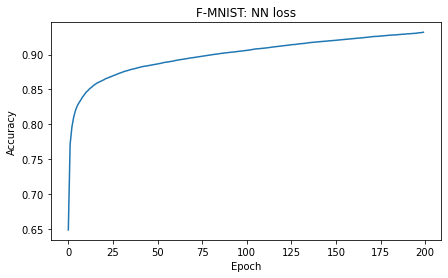

In [50]:
print_history(fashion_hist_nn, "F-MNIST: NN loss")

In [46]:
fashion_lenet = build_lenet()

In [51]:
fashion_hist_lenet = train(fashion_lenet, fashion_train_loader, ctx, fashion_epochs)

Epoch: 199, Batch: 117, Loss: 0.351629: 100%|██████████| 23600/23600 [46:29<00:00,  8.46it/s]


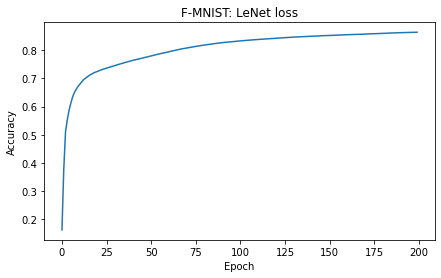

In [52]:
print_history(fashion_hist_lenet, "F-MNIST: LeNet loss")

In [53]:
fashion_net_acc = evaluate_acc(fashion_net, fashion_test_loader)
fashion_lenet_acc = evaluate_acc(fashion_lenet, fashion_test_loader)

print('Validaton Fashion NN: {} = {}'.format(*fashion_net_acc))
print('Validaton Fashion LeNet: {} = {}'.format(*fashion_lenet_acc))

Validaton Fashion NN: accuracy = 0.8914
Validaton Fashion LeNet: accuracy = 0.8561


In [76]:
from mxnet.gluon.model_zoo import vision

In [78]:
fashion_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [80]:
gluon_alexnet = vision.AlexNet(classes = 10)

In [74]:
def build_alexnet():
    net = nn.HybridSequential(prefix='LeNet_')
    with net.name_scope():
        net.add(
            nn.Conv2D(kernel_size=11, strides=(4,4), channels=96, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Conv2D(kernel_size=5, padding=(2,2), channels=256, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=384, activation="relu"),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=384, activation="relu"),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=256, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Flatten(),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(10, activation=None)
        )

    return net

In [72]:
alex_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

alex_train_data = gluon.data.vision.FashionMNIST(train=True).transform_first(fashion_transformer)
alex_test_data = gluon.data.vision.FashionMNIST(train=False).transform_first(fashion_transformer)

alex_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
alex_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

In [69]:
fashion_alexnet = build_alexnet()

In [70]:
print(fashion_alexnet)

HybridSequential(
  (0): Conv2D(None -> 96, kernel_size=(5, 5), stride=(3, 3))
  (1): Activation(relu)
  (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): Conv2D(None -> 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (4): Activation(relu)
  (5): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (6): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (7): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (8): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (9): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (10): Flatten
  (11): Dense(None -> 4096, Activation(relu))
  (12): Dropout(p = 0.5, axes=())
  (13): Dense(None -> 4096, Activati

In [81]:
fashion_hist_alexnet = train(gluon_alexnet, alex_train_loader, ctx, 25)

  0%|          | 0/2950 [00:00<?, ?it/s]


MXNetError: Traceback (most recent call last):
  File "../src/operator/nn/pooling.cc", line 193
MXNetError: Check failed: param.kernel[0] <= dshape_nchw[2] + 2 * param.pad[0]: kernel size (3) exceeds input (2 padded to 2)

# Resources

1. d2l book
<div>
    <img src="https://d2l.ai/_images/front.png" width="200"/>
</div>

[https://d2l.ai/index.html](https://d2l.ai/index.html)

2MXNet
<div>
    <img src="https://mxnet.apache.org/versions/1.9.0/assets/img/mxnet_logo.png" width="100"/>
</div>

MXNet provides optimized numerical computation for GPUs and distributed ecosystems, from the comfort of high-level environments like Python and R.
MXNet automates common workflows, so standard neural networks can be expressed concisely in just a few lines of code.

(Source: [https://mxnet.apache.org/](https://mxnet.apache.org/))
<br />

3. Gluon
<div>
    <img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/image-gluon-logo.png" width="200"/>
</div>

[Gluon](https://mxnet.apache.org/versions/1.4.1/gluon/index.html) library in Apache MXNet provides a clear, concise, and simple API for deep learning. It makes it easy to prototype, build, and train deep learning models without sacrificing training speed

(Source: [https://mxnet.apache.org/versions/1.4.1/gluon/index.html](https://mxnet.apache.org/versions/1.4.1/gluon/index.html))
<br />

4. ConvNet Playground
<div>
    <img src="https://convnetplayground.fastforwardlabs.com/images/icon.png" width="100"/>
</div>

[ConvNet Playground](https://convnetplayground.fastforwardlabs.com/#/)
Provides a view on CNN's internals. Discover hidden features & processing though layers

<br />

5. Know Your Data
**Know Your Data** is another bright service that helps one investigate the dataset.
See [https://knowyourdata.withgoogle.com/](https://knowyourdata.withgoogle.com/)